# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

from sklearn.linear_model import LinearRegression
from sklearn import metrics

#%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB
None


,count,mean,std,min,25%,50%,75%,max
идентификатор,200.0,100.500000,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
пористость скважины,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
проницаемость скважины,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
акустический импеданс,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
к. хрупкости скважины,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
общий органический углерод,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
к. отражения витринита,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
добыча газа в сутки,200.0,4311.219852,992.038414,2107.139414,3618.064513,4284.687348,5086.089761,6662.622385


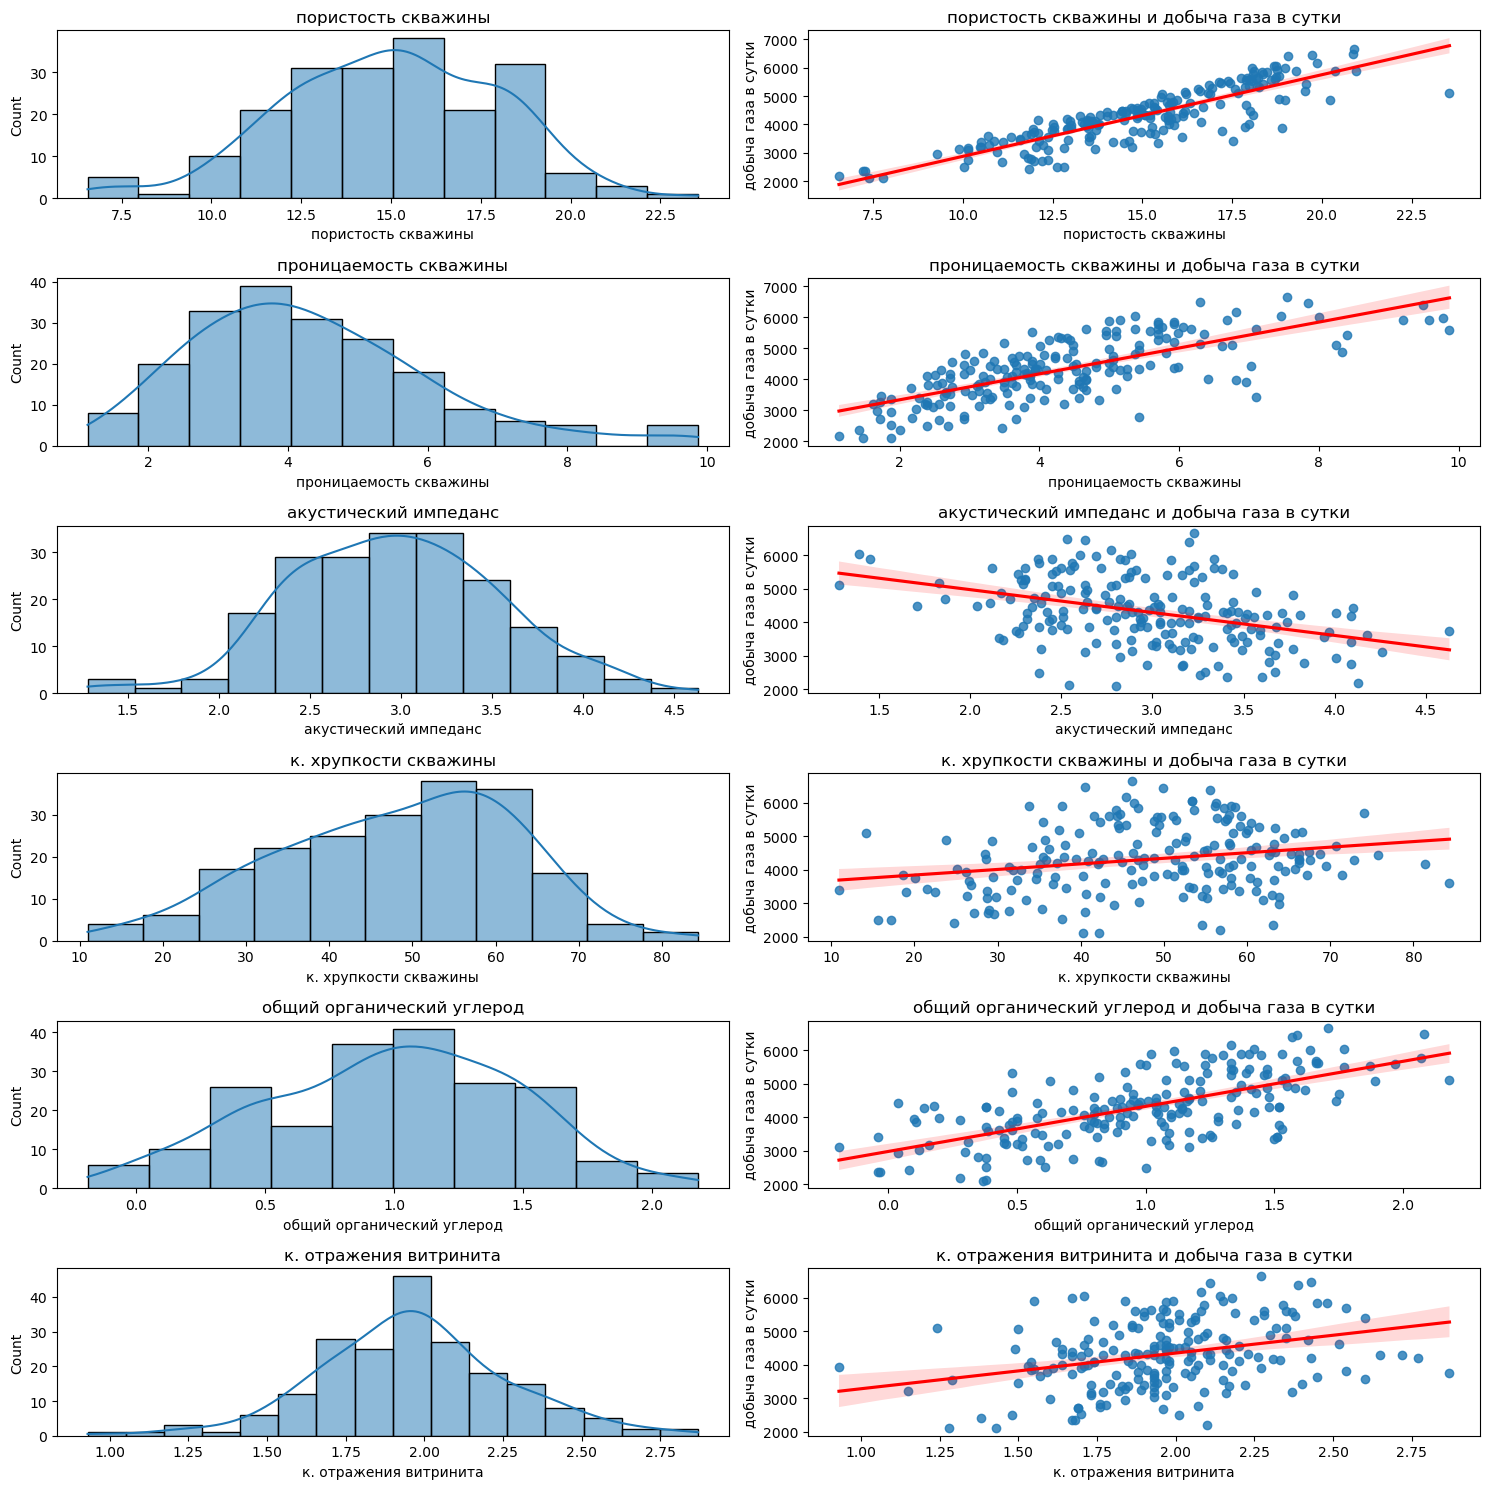

In [3]:
# посмотрим на общую информацию: количество объектов, пропуски, типы данных
print(data.info())

# переименуем буквенные обозначения столбцов в названия
data = data.rename(columns = {'Well': 'идентификатор', 'Por': 'пористость скважины', 'Perm': 'проницаемость скважины', 'AI': 'акустический импеданс',
                       'Brittle': 'к. хрупкости скважины', 'TOC': 'общий органический углерод',
                       'VR': 'к. отражения витринита', 'Prod': 'добыча газа в сутки'})

fig, axes = plt.subplots(6, 2, figsize=(15, 15))
# создаем цикл для всех признаков, кроме целевого и неинформативного идентификатора
for i, feature in enumerate(data.drop(['идентификатор','добыча газа в сутки'], axis=1).columns):
    # строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, kde=True, ax=axes[i][0])
    # название гистограммы
    histplot.set_title('{}'.format(feature))
    # строим диаграмму рассеяния + линейную регрессию в зависимости от целевого признака
    regplot = sns.regplot(data=data, x=feature, y='добыча газа в сутки', line_kws=dict(color="r"), ax=axes[i][1])
    # название графика
    regplot.set_title('{} и добыча газа в сутки'.format(feature));
plt.tight_layout()
# посмотрим на статистические показатели признаков
data.describe().T

Наибольшая зависимость целевого признака с факторами: пористость и проницаемость скважины.
В остальных признаках присутствует высокая дисперсия.
Все признаки числовые, пропусков нет, выбросов не наблюдается.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

,идентификатор,пористость скважины,проницаемость скважины,акустический импеданс,к. хрупкости скважины,общий органический углерод,к. отражения витринита,добыча газа в сутки
идентификатор,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
пористость скважины,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
проницаемость скважины,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
акустический импеданс,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
к. хрупкости скважины,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
общий органический углерод,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
к. отражения витринита,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
добыча газа в сутки,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


Ранг матрицы A: 8
Определитель матрицы A: 0.00073


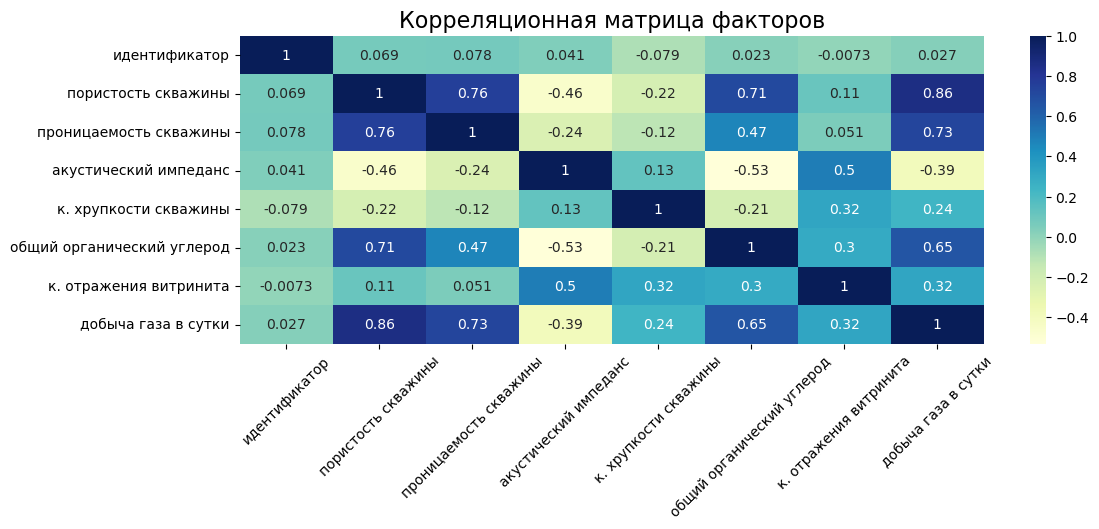

In [4]:
# Строим корреляционную матрицу
A = data.corr()
# Выводим корреляционную матрицу
display(A)
# Визуализируем матрицу
fig = plt.figure(figsize=(12, 4))
heatmap = sns.heatmap(data=A, annot=True, cmap='YlGnBu')
plt.xticks(rotation=45)
heatmap.set_title('Корреляционная матрица факторов', fontsize=16);
# Вычисляем ранг, детерминант и выводим их
rank = np.linalg.matrix_rank(A.values)
deter = np.round(np.linalg.det(A.values),5)
print('Ранг матрицы A:', rank)
print('Определитель матрицы A:', deter.round(5))

Сильнее всего с целевой переменной коррелируют пористость скважины, проницаемость скважины и показатель общего органического углерода.
Корреляционная матрица плохо обусловлена, определитель близок к нулю. Матрица почти вырождена. 
Матрица мультиколлинеарна и некоторые её факторы близки к линейной зависимости. Признаки мультиколлинеарности мы наблюдаем у пористости и проницаемости скважины, пористости и огранического углерода.
В данном случае мы можем решить задачу классическим методом МНК, но доверять полученным результатам не можем, так как мультиколлинеарность может привести к неустойчивости коэффициентов. Так же увеличивается разброс коэффициентов регрессии. Всё это усложняет интерпретацию параметров регрессии, так как они теряют смысл.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [5]:
# исключаем из данных целевую переменную
data_drop_gas = data.drop('добыча газа в сутки', axis=1)
# матрица наблюдений
X = np.column_stack((np.ones(data_drop_gas.shape[0]), data_drop_gas))     # добавляем вектор с единицами для вычисления свободного члена уравнения
# создаем вектор ответов: значения целевой переменной
y = data[['добыча газа в сутки']]
# решаем уравнение линейной регрессии по МНК
w = np.linalg.inv(X.T@X)@X.T@y
# полученные оценки коэффициентов модели
index = ['W0'] + data.drop('добыча газа в сутки', axis=1).columns.to_list()
w.index = index
w = w.rename(columns={'добыча газа в сутки': 'коэффициенты уравнения линейной регрессии'})
print(w.round())

                            коэффициенты уравнения линейной регрессии
W0                                                            -1232.0
идентификатор                                                     0.0
пористость скважины                                             230.0
проницаемость скважины                                          116.0
акустический импеданс                                          -365.0
к. хрупкости скважины                                            25.0
общий органический углерод                                      -78.0
к. отражения витринита                                          785.0


Признак идентификатор скважины никак не влияет на целевую переменную, так как его коэффициент почти равен нулю.

При увеличении пористости скважины на 1 процент добыча газав сутки увеличится на 230 млн. куб. футов.

При увеличении акустического импеданса на 1 кг/м2 * 10^6 добыча газа упадёт на 365 млн. куб. футов.

Увеличение к. отражения витринита на 1%  увеличивает добычу газа в сутки на 785 млн. кубических футов.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [6]:
x_new = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
# матрица значений новой скважины, объединенная с вектором-единицей для свободного интерсепта
x_new = np.array([list(x_new.values())])
x_new = np.column_stack((np.ones(1), x_new))
print(x_new)
# вычисляем скалярное произведение нового вектора признаков и коэффициентов регрессии
new_well = x_new@w.values
print(f'Прогноз добычи газа для новой скважины: {new_well.round(2)[0]}')
# Истинное значение добычи газа для предложенной скважины
y_true = 4748.315024   
print(f'Абсолютная ошибка прогноза для новой скважины: {(y_true - new_well).round(2)[0]}')

# прогнозируем для всей обучающей выборки добычу газа
y_pred = X@w.values
print(f'Средняя абсолютная ошибка для имеющихся скважин: {metrics.mean_absolute_error(y, y_pred).round(2)} млн. куб. футов.')
print(f'Средняя ошибка в процентах для имеющихся скважин: {metrics.mean_absolute_percentage_error(y, y_pred)*100:.2f}%')

[[  1.   106.    15.32   3.71   3.29  55.99   1.35   2.42]]
Прогноз добычи газа для новой скважины: [4723.06]
Абсолютная ошибка прогноза для новой скважины: [25.25]
Средняя абсолютная ошибка для имеющихся скважин: 153.62 млн. куб. футов.
Средняя ошибка в процентах для имеющихся скважин: 3.63%


Абсолютная ошибка прогноза для новой скважины 25.25 млн куб. футов.

Абсолютная ошибка по прогнозам добычи газа в сутки с имеющихся скважин 153.6 млн куб. футов, что составляет около 3.6% является хорошим показателем.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [7]:
# Сравнение коэффициентов корреляции и регрессии
compare_df = pd.merge(A['добыча газа в сутки'].round(3), w.round(3), left_index=True, right_index=True)
compare_df.drop(labels='идентификатор', inplace = True)
compare_df = compare_df.rename(columns = {'добыча газа в сутки': 'к. корреляции', 'коэффициенты уравнения линейной регрессии': 'к. регресиии'})
display(compare_df)

,к. корреляции,к. регресиии
пористость скважины,0.862,230.179
проницаемость скважины,0.727,116.239
акустический импеданс,-0.391,-365.202
к. хрупкости скважины,0.237,24.994
общий органический углерод,0.654,-78.401
к. отражения витринита,0.323,785.260


 Фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции это общий органический углерод (*TOC*). Вероятно это следствие того, что корреляционная матрица плохо обусловлена, поэтому признак у которого положительная корреляция имеет отрицательный коэффициент.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [8]:
# Cоздадим таблицу с матрицей корреляций и выберем признаки для удаления
display(data.corr().style.highlight_between(left=0.700, right = 0.999, color='orange')\
    .highlight_between(subset='добыча газа в сутки', left=0.00, right = 0.05, color='cyan'))

# Удалим выбранные признаки и целевую переменную из данных
data_crop = data.drop(['идентификатор', 'проницаемость скважины', 'общий органический углерод', 'добыча газа в сутки'], axis=1)
# Cоздаем матрицу наблюдений после удаления признаков
X_crop = np.column_stack((np.ones(200), data_crop))
# решаем уравнение линейной регрессии по МНК
w_crop = np.linalg.inv(X_crop.T@X_crop)@X_crop.T@y
# Добавляем названия факторов
w_crop.index = ['W0'] + data_crop.columns.to_list()
w_crop.rename(columns={'добыча газа в сутки': 'коэффициенты регрессии'}, inplace=True)
w.rename(columns={'коэффициенты уравнения линейной регрессии': 'коэффициенты регрессии'}, inplace=True)

print('Коэффициенты регрессии до удаления факторов:', w.round(), sep='\n')
print()
print('Коэффициенты регрессии после удаления факторов:', w_crop.round(), sep='\n')
print()
# Прогнозируем целевую перемнную
y_pred = X_crop@w_crop
print(f'Средняя абсолютная ошибка для имеющихся скважин MAPE: {metrics.mean_absolute_error(y, y_pred).round(2)} млн. куб. футов.')
print('Средняя ошибка в процентах новой модели линейной регрессии MAPE: {:.2f} %'\
      .format(metrics.mean_absolute_percentage_error(y, y_pred)*100))

,идентификатор,пористость скважины,проницаемость скважины,акустический импеданс,к. хрупкости скважины,общий органический углерод,к. отражения витринита,добыча газа в сутки
идентификатор,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
пористость скважины,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
проницаемость скважины,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
акустический импеданс,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
к. хрупкости скважины,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
общий органический углерод,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
к. отражения витринита,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
добыча газа в сутки,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


Коэффициенты регрессии до удаления факторов:
                            коэффициенты регрессии
W0                                         -1232.0
идентификатор                                  0.0
пористость скважины                          230.0
проницаемость скважины                       116.0
акустический импеданс                       -365.0
к. хрупкости скважины                         25.0
общий органический углерод                   -78.0
к. отражения витринита                       785.0

Коэффициенты регрессии после удаления факторов:
                        коэффициенты регрессии
W0                                     -1835.0
пористость скважины                      293.0
акустический импеданс                   -200.0
к. хрупкости скважины                     28.0
к. отражения витринита                   517.0

Средняя абсолютная ошибка для имеющихся скважин MAPE: 171.43 млн. куб. футов.
Средняя ошибка в процентах новой модели линейной регрессии MAPE: 4.04 %


После удаления скоррелированных данных, при увеличении пористости скважины(Por) на 1 процент, медианное значение добычи газа в сутки увеличится на 293 млн. куб. футов. А если акустический импеданс (AI) увеличится на 1 кг/м2 * 10^6 медианное значение целевой метрики упадёт на 200 млн. куб. футов.

Значение метрик изменилось. Новая модель ошибается примерно на 0.4% больше.

Противоречие коэффициентов линейной регрессии и корреляции удалось исключить.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [9]:
# Обучаем модель
lr = LinearRegression()
lr.fit(X_crop, y)

print('Коэффициенты модели:', lr.coef_.round())

# Предсказываем
y_pred = lr.predict(X_crop)
print()

print(f'Средняя абсолютная ошибка: {metrics.mean_absolute_error(y, y_pred).round(1)} млн. куб. футов.')
print(f'Средняя ошибка в процентах: {metrics.mean_absolute_percentage_error(y, y_pred)*100:.2f}%')

Коэффициенты модели: [[   0.  293. -200.   28.  517.]]

Средняя абсолютная ошибка: 171.4 млн. куб. футов.
Средняя ошибка в процентах: 4.04%


Рассчет линейной регрессии для прогноза целевой метрики вручную и с помощью библиотеки sklearn дает идентичные результаты.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [10]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [11]:
# Матрица наблюдений без признаков, исключенных на предыдущем этапе
X = data.drop(['идентификатор', 'проницаемость скважины', 'общий органический углерод', 'добыча газа в сутки'], axis=1)
# вектор правильных ответов
y = data['добыча газа в сутки']

# Стандартизируем данные
scaler = StandardScaler()
X_scal = scaler.fit_transform(X)

# Полиномиальные признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scal)
print('Кол-во факторов после генерации полиномиальных признаков:', X_poly.shape[1])

# Создаём модель линейной регрессии
lr = LinearRegression()

# Оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results  = cross_validate(lr, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print()
print('MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results['test_score'].mean() * 100))

Кол-во факторов после генерации полиномиальных признаков: 34

MAPE на тренировочных фолдах: 1.773 %
MAPE на валидационных фолдах: 2.681 %


Качество модели значительно улучшилось, ошибка небольшая, как на тренировочных данных, так и на валидационных выборках, разброса между ними нет, переобучения у модели не произошло.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [12]:
# задаем сетку гиперпараметров для рандомного перебора
param_distributions= [{'alpha': np.linspace(0.1, 5, 100)}      # коэффициент регуляризации
]
# Создаем объект класса RandomizedSearchCV
random_search_lasso = RandomizedSearchCV(
    estimator=Lasso(random_state=42),                                      # алгоритм линейной регрессии с L1-регуляризацией
    param_distributions=param_distributions,                               # сетка гиперпараметров
    cv=5,                                                                  # количество фолдов при кросс-валидации
    scoring='neg_mean_absolute_percentage_error',                          # метрика оценки качества MAPE
    n_iter = 50,                                                           # количество случайных комбинаций 
    n_jobs = -1
)  

# Cоздаём модель линейной регрессии c L1-регуляризацией
random_search_lasso.fit(X_poly, y) 
# Выводим наилучшее значение гипермараметра
print('Наилучшие значения alpha: {}'.format(random_search_lasso.best_params_['alpha'].round(3)))
lasso = Lasso(alpha=random_search_lasso.best_params_['alpha'], random_state=42)
# Оцениваем качество модели на кросс-валидации
cv_results_l = cross_validate(lasso, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results_l['train_score'].mean()*100))
print('MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results_l['test_score'].mean()*100))

Наилучшие значения alpha: 4.654
MAPE на тренировочных фолдах: 1.822 %
MAPE на валидационных фолдах: 2.276 %


Качество модели улучшилось, ошибка небольшая, как на тренировочных данных, так и на валидационных выборках.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [13]:
# задаем сетку гиперпараметров для рандомного перебора
param_distributions= [{'alpha': np.linspace(0.1, 5, 100)}      # коэффициент регуляризации
]
# Создаем объект класса RandomizedSearchCV
random_search_ridge = RandomizedSearchCV(
    estimator=Ridge(random_state=42),                                      # алгоритм линейной регрессии с L1-регуляризацией
    param_distributions=param_distributions,                               # сетка гиперпараметров
    cv=5,                                                                  # количество фолдов при кросс-валидации
    scoring='neg_mean_absolute_percentage_error',                          # метрика оценки качества MAPE
    n_iter = 50,                                                           # количество случайных комбинаций 
    n_jobs = -1
)  

# Cоздаём модель линейной регрессии c L1-регуляризацией
random_search_ridge.fit(X_poly, y) 
print('Наилучшие значения alpha: {}'.format(random_search_ridge.best_params_['alpha'].round(3)))
ridge  = Ridge(alpha=random_search_ridge.best_params_['alpha'], random_state=42)
# Оцениваем качество модели на кросс-валидации
cv_results_r = cross_validate(ridge , X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results_r['train_score'].mean()*100))
print('MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results_r['test_score'].mean()*100))

Наилучшие значения alpha: 0.248
MAPE на тренировочных фолдах: 1.775 %
MAPE на валидационных фолдах: 2.673 %


Регуляризация L2 хуже справилась с задачей чем регуляризация L1. Показатель на валидационных фолдах откатился к результатам классической МНК модели.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [14]:
# Задаем сетку гиперпараметров для рандомного перебора
param_distributions= [{'alpha': np.linspace(0.1, 5, 100, dtype=float),      # коэффициент L1-регуляризации
              'l1_ratio': np.linspace(0.01, 1, 100, dtype=float)}           # коэффициент L2-регуляризации
]
# Создаем объект класса RandomizedSearchCV
random_search_elast = RandomizedSearchCV(
    estimator=ElasticNet(random_state=42),                                 # алгоритм линейной регрессии с L1 и L2-регуляризацией
    param_distributions=param_distributions,                               # сетка гиперпараметров
    cv=5,                                                                  # количество фолдов при кросс-валидации
    scoring='neg_mean_absolute_percentage_error',                          # метрика оценки качества MAPE
    n_iter = 300,                                                          # количество случайных комбинаций 
    n_jobs = -1
)  
# Cоздаём модель линейной регрессии c L1- и L2-регуляризациями
random_search_elast.fit(X_poly, y) 
print('Наилучшие значения l1-ratio: {}'.format(random_search_elast.best_params_['l1_ratio'].round(3)))
print('Наилучшие значения alpha: {}'.format(random_search_elast.best_params_['alpha'].round(3)))
elastic = ElasticNet(alpha=random_search_elast.best_params_['alpha'], l1_ratio=random_search_elast.best_params_['l1_ratio'],
                     max_iter = 5000, random_state=42)
# Оцениваем качество модели на кросс-валидации
cv_results_eln = cross_validate(elastic, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.3f} %'.format(-cv_results_eln['train_score'].mean()*100))
print('MAPE на валидационных фолдах: {:.3f} %'.format(-cv_results_eln['test_score'].mean()*100))

Наилучшие значения l1-ratio: 1.0
Наилучшие значения alpha: 4.109
MAPE на тренировочных фолдах: 1.815 %
MAPE на валидационных фолдах: 2.282 %


Релультаты показывают, что лучше воспользоваться регуляризацией L1 без регуляризации L2,
 поскольку качество L1 не уступает ElasticNet.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [15]:

# Формат числовой ячейки
pd.set_option('display.float_format', '{:.3f}'.format)
# Таблица с результатами всех построенных моделей
all_data = pd.DataFrame({
    'Model': ['Linear', 'Polinomial', 'Lasso', 'Ridge', 'ElasticNet'],
    'Hyperparameters': [False,
                        False,
                        random_search_lasso.best_params_['alpha'].round(3),
                        random_search_ridge.best_params_['alpha'].round(3), 
                        str(random_search_elast.best_params_['l1_ratio'].round(2))+'; '+
                        str(random_search_elast.best_params_['alpha'].round(3))
                       ],
    'PolinomialFeatures': [False, True, True, True, True],
    'MAPE on train': [metrics.mean_absolute_percentage_error(y, y_pred)*100,
                      -cv_results['train_score'].mean()*100,
                      -cv_results_l['train_score'].mean()*100, 
                      -cv_results_r['train_score'].mean()*100, 
                      -cv_results_eln['train_score'].mean()*100
                     ],
    'MAPE on valid': [None,
                      -cv_results['test_score'].mean()*100, 
                      -cv_results_l['test_score'].mean()*100,
                      -cv_results_r['test_score'].mean()*100,
                      -cv_results_eln['test_score'].mean()*100
                     ]
})

display(all_data)

,Model,Hyperparameters,PolinomialFeatures,MAPE on train,MAPE on valid
0,Linear,False,False,4.044,NaN
1,Polinomial,False,True,1.773,2.681
2,Lasso,4.654,True,1.822,2.276
3,Ridge,0.248,True,1.775,2.673
4,ElasticNet,1.0; 4.109,True,1.815,2.282


Больше всего на добычу газа влияют: пористость скважины - положительно при увеличении, акустический импеданс - отрицательно при увеличении.

Существенного разброса между значениями метрик на тренировочных и валидационнных фолдах нет, следовательно модели не переобучились.

Лучшей моделью, которая решает задачу с минимальной ошибкой, является линейная регрессия на полиномиальных признаках с L1-регуляризацией.